# **Dependancy**

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
pip install deepxde

# **Prepare Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'
p1 = genfromtxt('T_q100_v200_T25_D100.csv', delimiter=',')
times = genfromtxt('time.csv', delimiter=',')
times = times.reshape((100,1))
times.shape
times[0:5]
points = p1[:, 1:3]
points.shape
temps = p1[:, 5:]
temps.shape
train_number = 1681
num_p = 1681
# test_number = 10 * 100

/content/drive/My Drive/Analytical Data


In [5]:
temps.shape

(1681, 100)

Re-arranging

In [6]:
new_points = np.zeros((1681, 3))
for i in range(1681):
  for j in range(1):
    new_points[i + j] = [points[i][0], points[i][1], times[j] * 1000] # y, z, t 

new_temps = temps[:,0:1]
new_temps[0:10]

array([[133.85 ],
       [133.19 ],
       [131.25 ],
       [128.13 ],
       [123.99 ],
       [119.03 ],
       [113.46 ],
       [107.51 ],
       [101.36 ],
       [ 95.204]])

In [9]:
new_points[0:10]

array([[ 1.    ,  1.    ,  1.0971],
       [ 2.    ,  1.    ,  1.0971],
       [ 3.    ,  1.    ,  1.0971],
       [ 4.    ,  1.    ,  1.0971],
       [ 5.    ,  1.    ,  1.0971],
       [ 6.    ,  1.    ,  1.0971],
       [ 7.    ,  1.    ,  1.0971],
       [ 8.    ,  1.    ,  1.0971],
       [ 9.    ,  1.    ,  1.0971],
       [10.    ,  1.    ,  1.0971]])

**Randomized**

In [ ]:
 idx = np.random.randint(168100, size=1000)
 new_points=new_points[idx,:]
 new_temps = new_temps[idx,:]

**Non-randomized**

In [10]:
new_points=new_points[0:num_p,:]
new_temps = new_temps[0:num_p,:]

### Now we have an input of size 168100 by 3 and output of size 168100 by 1

In [11]:
train_x = new_points[0:train_number]
train_y = new_temps[0:train_number]
test_x = new_points[train_number:]
test_y = new_temps[train_number:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1681, 3)
(1681, 1)
(0, 3)
(0, 1)


In [12]:
map_dict =  {}
for i in range(len(train_x)):
  map_dict[(train_x[i][0], train_x[i][1], train_x[i][2])] = train_y[i]

In [13]:
train_x[0:10] # y, z, time

array([[ 1.    ,  1.    ,  1.0971],
       [ 2.    ,  1.    ,  1.0971],
       [ 3.    ,  1.    ,  1.0971],
       [ 4.    ,  1.    ,  1.0971],
       [ 5.    ,  1.    ,  1.0971],
       [ 6.    ,  1.    ,  1.0971],
       [ 7.    ,  1.    ,  1.0971],
       [ 8.    ,  1.    ,  1.0971],
       [ 9.    ,  1.    ,  1.0971],
       [10.    ,  1.    ,  1.0971]])

In [14]:
train_y[0:10]

array([[133.85 ],
       [133.19 ],
       [131.25 ],
       [128.13 ],
       [123.99 ],
       [119.03 ],
       [113.46 ],
       [107.51 ],
       [101.36 ],
       [ 95.204]])

# **Model and PINN**

**This shows the equation**
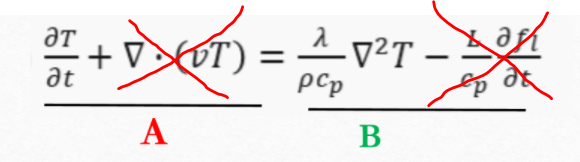

In [ ]:
import deepxde as dde
dde.geometry.is_rectangle(vertices=[(0, 0), (0, 41), (41, 41), (41, 0)])
# geom = dde.geometry.Rectangle((0,0), (41,41))
# geom.is_valid(vertices= [[(0, 0), (0, 41), (41, 41), (41, 0)]])

In [ ]:
import numbers
class PointSetBC(object):
    """Dirichlet boundary condition for a set of points.
    Compare the output (that associates with `points`) with `values` (target data).
    Args:
        points: An array of points where the corresponding target values are known and used for training.
        values: An array of values that gives the exact solution of the problem.
        component: The output component satisfying this BC.
    """

    def __init__(self, points, values, component=0):
        self.points = np.array(points)
        if not isinstance(values, numbers.Number) and values.shape[1] != 1:
            raise RuntimeError(
                "PointSetBC should output 1D values. Use argument 'component' for different components."
            )
        self.values = values
        self.component = component

    def collocation_points(self, X):
        return self.points

    def error(self, X, inputs, outputs, beg, end):
        return outputs[beg:end, self.component : self.component + 1] - self.values

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf

# power = 100, speed = 200
# y(the input to the function) represents T(temperature) here.
# dT_t = D * (dT_yy + dT_zz)
def pde(x, y):
  dy_x = tf.gradients(y, x)[0]
  dy_x1, dy_x2, dy_t = dy_x[:, 0:1], dy_x[:, 1:2], dy_x[:, 2:]
  dy_x1x1 = tf.gradients(dy_x1, x)[0][:, 0:1]
  dy_x2x2 = tf.gradients(dy_x2, x)[0][:, 1:2]
  return (
  dy_t - (dy_x1x1 - dy_x2x2)
  # + tf.exp(-x[:, 2:]) * (tf.sin(np.pi * (x[:, 0:1] + x[:, 1:2])))
  # - tf.exp(-x[:, 2:]) * (2 * np.pi ** 2 * tf.sin(np.pi * (x[:, 0:1] + x[:, 1:2])))
  )

# x=np.zeros((NumData,1))
# xd=np.zeros((NumData,1))
# xdd=np.zeros((NumData,1))
# Fe=np.zeros((NumData,1))

# for i in range(NumData-1):
    
#     if i==0:
#         x[i-1]=xm1
#         x[i]=x0
#     Fe[i]=Force[i]-(K-a2*M)*x[i]-(a0*M-a1*C)*x[i-1]
    
#     x[i+1]=Fe[i]/Ke
#     xd[i]=a1*(-x[i-1]-x[i+1])
#     xdd[i]=a0*(x[i-1]-2*x[i]+x[i+1])

def func(x):
  return np.full((len(x), 1), 10e-2)

def funcic(x): return np.full((len(x), 1), 25)

def funcbc(x):  # x = the collection of the points on the boundary 
  result = np.zeros((len(x), 1))
  for i in range(len(x)):
    result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
  return result

def solution(x) : return train_y

geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
# bc = PointSetBC(train_x, train_y)
# bc = dde.boundary_conditions.OperatorBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, funcic, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    anchors = train_x,
    solution = solution
)


layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)


model = dde.Model(data, net)

callback = dde.callbacks.EarlyStopping(min_delta=0.001, patience=10000)

model.compile("adam", lr=0.001,metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=30000, callbacks = [callback])

#dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.066554 s



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.822943 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.37e-03, 2.69e+03, nan]         [1.37e-03, 0.00e+00, 0.00e+00]    [9.94e-01]    
1000      [1.15e-08, 9.75e+02, nan]         [1.15e-08, 0.00e+00, 0.00e+00]    [4.77e-01]    
2000      [2.26e-09, 8.67e+02, nan]         [2.26e-09, 0.00e+00, 0.00e+00]    [4.65e-01]    
3000      [1.25e-09, 8.66e+02, nan]         [1.25e-09, 0.00e+00, 0.00e+00]    [4.70e-01]    
4000      [1.37e-09, 8.66e+02, nan]         [1.37e-09, 0.00e+00, 0.00e+00]    [4.71e-01]    
5000      [5.43e-02, 8.46e+02, nan]         [5.43e-02, 0.00e+00, 0.00e+00]    [4.56e-01]    
6000      [1.42e-02, 1.16e+02, nan]         [1.42e-02, 0.00e+00, 0.00e+00]    [1.89e-01]    
7000      [2.58e-02, 3.13e+01, nan]         [2.58e-02, 0.00e+00, 0.00e+00]    [1.59e-01]    
8000      [1.52e-02, 7.87e+00, nan]         [1.52e-02, 0.00e+00, 0.00e+00]    [1.50e-01]   

**Finding Boundary**

In [23]:
import deepxde as dde
def func(x):
  return np.full((len(x), 1), 10e-2)
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
#geom = dde.geometry.geometry_2d.Polygon([(0, 0), (0, 40), (41, 41), (41, 0)])
timedomain = dde.geometry.TimeDomain(0, 0.01) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# bc = PointSetBC(train_x, train_y)
bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
# bc = dde.boundary_conditions.PointSet(train_x)

In [24]:
boundary = bc.collocation_points(train_x)
temps_on_boundary = np.zeros((len(boundary), 1))
for i in range(len(boundary)):
  temps_on_boundary[i] = map_dict[(boundary[i][0], boundary[i][1], boundary[i][2])] 
all_boundary = np.concatenate((boundary, temps_on_boundary), axis = 1)

**Plotting Boundary**

In [ ]:
all_boundary.shape

(103, 4)

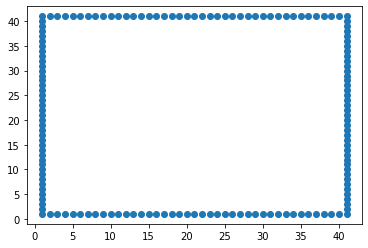

In [25]:
import matplotlib.pyplot as plt
plt.scatter(all_boundary[:,0], all_boundary[:,1]) 

In [19]:
pred_y = model.predict(train_x)

Predicting...
'predict' took 0.035659 s



In [20]:
train_x[0:10]

array([[ 1.    ,  1.    ,  1.0971],
       [ 2.    ,  1.    ,  1.0971],
       [ 3.    ,  1.    ,  1.0971],
       [ 4.    ,  1.    ,  1.0971],
       [ 5.    ,  1.    ,  1.0971],
       [ 6.    ,  1.    ,  1.0971],
       [ 7.    ,  1.    ,  1.0971],
       [ 8.    ,  1.    ,  1.0971],
       [ 9.    ,  1.    ,  1.0971],
       [10.    ,  1.    ,  1.0971]])

In [21]:
 print(train_y[0:10]) #/ np.linalg.norm(test_y[0:10])
 print(np.mean(train_y[0:10]))

[[133.85 ]
 [133.19 ]
 [131.25 ]
 [128.13 ]
 [123.99 ]
 [119.03 ]
 [113.46 ]
 [107.51 ]
 [101.36 ]
 [ 95.204]]
118.69739999999999


In [22]:
pred_y[0:10]

array([[129.04106 ],
       [129.03746 ],
       [128.96046 ],
       [127.72884 ],
       [124.11156 ],
       [119.12802 ],
       [113.456314],
       [107.53181 ],
       [101.335106],
       [ 95.183624]], dtype=float32)

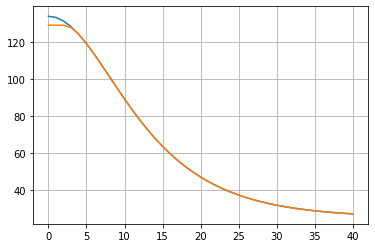

In [30]:
axis = [i for i in range(41)]
# plt.plot(train_y)
fig, ax = plt.subplots()
ax.plot(axis, train_y[0:41])
ax.plot(axis, pred_y[0:41])
plt.grid()

In [ ]:
dde.metrics.l2_relative_error(test_y/ np.linalg.norm(test_y), pred_y)

1.0597508182205848

In [ ]:
data.train_x.shape#x, t

(9000, 3)

In [ ]:
data.test_x.shape# u

(1152, 3)

In [ ]:
predictions = model.predict(train_x)

Predicting...
'predict' took 0.070050 s



In [ ]:
predictions.shape

(134500, 1)

In [ ]:
predictions[101:106]

array([[-0.16441411],
       [-0.16441411],
       [-0.16441375],
       [-0.16441375],
       [-0.1644139 ]], dtype=float32)

# **Plotting**

Tensor("Mean_2:0", shape=(), dtype=float32)


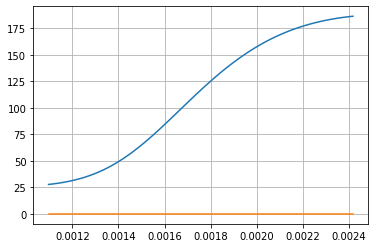

In [ ]:
point_number = 100
predicted_temps = predictions[(point_number-1) * 100 : point_number * 100]
real_temps = test_y[(point_number-1) * 100 : point_number * 100]
fig, ax = plt.subplots()
ax.plot(times, real_temps)
ax.plot(times, predicted_temps)
plt.grid()
print(tf.keras.losses.MSE(temps[point_number], predictions[point_number]))